In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import umap
import numpy as np
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import joblib

/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
SHEET_CSV_URL = "https://docs.google.com/spreadsheets/d/19gFONrR0d4Ed57gGWtUqVHjjvw85WgysCh9ukhiTmBM/export?format=csv"
df = pd.read_csv(SHEET_CSV_URL)

In [7]:
df.head()

,date,title,url,publication,author,stance,topic_category,content
0,4/11/2025,Mapping Attacks on LGBTQ Rights in U.S. State ...,https://www.aclu.org/legislative-attacks-on-lg...,ACLU,None listed,Pro,1,No text content
1,4/3/25,The Human Toll of Trump's Anti-Trans Crusade,https://www.aclu.org/news/lgbtq-rights/the-hum...,ACLU,Lisa Francois,Pro,2,President Donald Trump’s assault on transgende...
2,4/3/25,Perkins et al. v. State (HB 121),https://www.aclu.org/cases/perkins-et-al-v-state,ACLU,None listed,Pro,3,"HB 121, which took effect on March 27, 2025, i..."
3,2/11/2025,Montana Senate endorses bill tying bathrooms t...,https://www.kpax.com/news/montana-senate-endor...,KPAX (local news),Jonathon Ambarian,Anti,"3, 10, 14, 17",A bill that would require transgender people i...
4,3/26/25,Library Patrons Sue Greenville County Over Wid...,https://www.aclu.org/press-releases/library-pa...,ACLU,None listed,Pro,4,"GREENVILLE, S.C. – Local library patrons, with..."


In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('using device:', device)

using device: mps


In [10]:
# combine title and text
df['full_text'] = df['title'].fillna('') + ' ' + df['content'].fillna('')

# encode stance labels
le = LabelEncoder()
df['stance_encoded'] = le.fit_transform(df['stance'].str.lower())

print(le.classes_)

['anti' 'pro']


In [11]:
def encode_text(text_list, tokenizer, device):
    encodings = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return encodings['input_ids'].to(device), encodings['attention_mask'].to(device)

def encode_texts_batched(text_list, tokenizer, model, device, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Encoding Batches"):
        batch_texts = text_list[i:i+batch_size]
        input_ids, attention_mask = encode_text(batch_texts, tokenizer, device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_emb = outputs.last_hidden_state[:, 0]
        embeddings.append(batch_emb.cpu())
    return torch.cat(embeddings, dim=0)

In [12]:
class EmbeddingNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.embedding_dim = 768
        self.fc = nn.Linear(self.embedding_dim, 128)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        return self.fc(pooled_output)

In [14]:
model = SentenceTransformer("all-MiniLM-L6-v2")
full_embeddings = model.encode(df['content'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]


In [8]:
all_texts = df['full_text'].tolist()
full_embeddings = encode_texts_batched(all_texts, tokenizer, bert, device)

Encoding Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding Batches: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


In [9]:
class BatchMiner:
    def __init__(self, embeddings, labels, n_neighbors=20):
        self.embeddings = embeddings
        self.labels = labels
        self.n_neighbors = n_neighbors

        self.nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
        self.nn.fit(embeddings)

    def get_hard_triplets(self):
        triplets = []
        for idx, emb in enumerate(self.embeddings):
            label = self.labels[idx]
            distances, indices = self.nn.kneighbors([emb])
            indices = indices.flatten()

            pos_idx = None
            neg_idx = None

            for i in indices[::-1]:  # farthest positive
                if i != idx and self.labels[i] == label:
                    pos_idx = i
                    break
            for i in indices:  # nearest negative
                if self.labels[i] != label:
                    neg_idx = i
                    break

            if pos_idx is not None and neg_idx is not None:
                triplets.append((idx, pos_idx, neg_idx))
        
        return triplets

In [10]:
miner = BatchMiner(full_embeddings.numpy(), df['stance_encoded'].values)
triplets = miner.get_hard_triplets()

In [11]:
class TripletDatasetFromIndices(Dataset):
    def __init__(self, df, triplets):
        self.df = df.reset_index(drop=True)
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]

        anchor_text = self.df.loc[anchor_idx, 'full_text']
        positive_text = self.df.loc[pos_idx, 'full_text']
        negative_text = self.df.loc[neg_idx, 'full_text']
        anchor_label = self.df.loc[anchor_idx, 'stance_encoded']

        return anchor_text, positive_text, negative_text, anchor_label

In [12]:
dataset = TripletDatasetFromIndices(df, triplets)

In [13]:
class EmbeddingNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.embedding_dim = 768
        self.fc = nn.Linear(self.embedding_dim, 128)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        return self.fc(pooled_output)

In [14]:
class EmbeddingNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.embedding_dim = 768
        self.fc = nn.Linear(self.embedding_dim, 128)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        return self.fc(pooled_output)

In [15]:
model = EmbeddingNet(bert).to(device)

In [16]:
def train_triplet(model, dataset, epochs=10, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.TripletMarginLoss(margin=0.8)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for anchor, positive, negative, _ in pbar:
            anchor_ids, anchor_mask = encode_text(anchor, tokenizer, device)
            positive_ids, positive_mask = encode_text(positive, tokenizer, device)
            negative_ids, negative_mask = encode_text(negative, tokenizer, device)

            anchor_emb = model(anchor_ids, anchor_mask)
            positive_emb = model(positive_ids, positive_mask)
            negative_emb = model(negative_ids, negative_mask)

            loss = criterion(anchor_emb, positive_emb, negative_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
    
    return losses

In [17]:
def plot_loss(losses):
    plt.plot(losses, marker='o')
    plt.title("Triplet Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [18]:
def visualize_embeddings(model, df, n_samples=200):
    model.eval()
    
    texts = df.sample(n=n_samples, random_state=42)['full_text'].tolist()
    labels = df.sample(n=n_samples, random_state=42)['stance_encoded'].tolist()
    
    input_ids, attention_mask = encode_text(texts, tokenizer, device)
    embeddings = model(input_ids, attention_mask).detach().cpu().numpy()
    
    reducer = umap.UMAP()
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title('UMAP projection of Embeddings')
    plt.colorbar(scatter, label='Stance')
    plt.show()
    
    return emb_2d, labels

In [19]:
def plot_decision_boundary(embeddings_2d, labels):
    X = np.array(embeddings_2d)
    y = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title("Decision Boundary on UMAP Embeddings")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.colorbar(scatter, label='Stance')
    plt.show()

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

In [20]:
# train
losses = train_triplet(model, dataset, epochs=10, batch_size=16)

Epoch 10/10: 100%|██████████| 16/16 [00:48<00:00,  3.06s/it, loss=0.876]


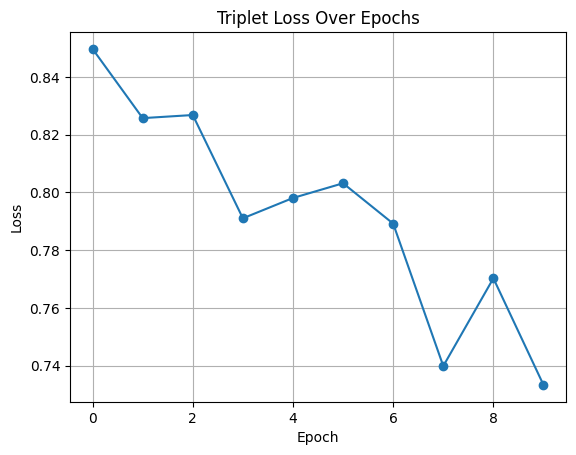

In [21]:
# plot training loss
plot_loss(losses)

In [25]:
# embed + visualize
embeddings_2d, labels = visualize_embeddings(model, df)

AttributeError: module 'umap' has no attribute 'UMAP'

In [26]:
# plot decision boundary
plot_decision_boundary(embeddings_2d, labels)

NameError: name 'embeddings_2d' is not defined

In [22]:
# 1. batched final embedding extractor
def get_embeddings_from_model(df, model, tokenizer, device, batch_size=16):
    model.eval()
    embeddings = []
    texts = df['full_text'].tolist()

    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding Final Embeddings"):
        batch_texts = texts[i:i+batch_size]
        input_ids, attention_mask = encode_text(batch_texts, tokenizer, device)
        with torch.no_grad():
            batch_emb = model(input_ids, attention_mask)
        embeddings.append(batch_emb.cpu())

    return torch.cat(embeddings, dim=0)

# 2. run encoding
final_embeddings = get_embeddings_from_model(df, model, tokenizer, device)

# 3. attach to dataframe
df['embedding'] = final_embeddings.numpy().tolist()

# 4. (optional) save to CSV
df.to_csv('articles_with_embeddings.csv', index=False)

Encoding Final Embeddings: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


In [23]:
df

,date,title,url,publication,author,stance,topic_category,content,full_text,stance_encoded,embedding
0,4/11/2025,Mapping Attacks on LGBTQ Rights in U.S. State ...,https://www.aclu.org/legislative-attacks-on-lg...,ACLU,None listed,Pro,1,No text content,Mapping Attacks on LGBTQ Rights in U.S. State ...,1,"[0.5456031560897827, 0.2706182897090912, 0.048..."
1,4/3/25,The Human Toll of Trump's Anti-Trans Crusade,https://www.aclu.org/news/lgbtq-rights/the-hum...,ACLU,Lisa Francois,Pro,2,President Donald Trump’s assault on transgende...,The Human Toll of Trump's Anti-Trans Crusade P...,1,"[0.4251714050769806, 0.39493420720100403, -0.1..."
2,4/3/25,Perkins et al. v. State (HB 121),https://www.aclu.org/cases/perkins-et-al-v-state,ACLU,None listed,Pro,3,"HB 121, which took effect on March 27, 2025, i...","Perkins et al. v. State (HB 121) HB 121, which...",1,"[0.4237897992134094, 0.3935093879699707, -0.30..."
3,2/11/2025,Montana Senate endorses bill tying bathrooms t...,https://www.kpax.com/news/montana-senate-endor...,KPAX (local news),Jonathon Ambarian,Anti,"3, 10, 14, 17",A bill that would require transgender people i...,Montana Senate endorses bill tying bathrooms t...,0,"[0.3479016125202179, 0.41807496547698975, -0.2..."
4,3/26/25,Library Patrons Sue Greenville County Over Wid...,https://www.aclu.org/press-releases/library-pa...,ACLU,None listed,Pro,4,"GREENVILLE, S.C. – Local library patrons, with...",Library Patrons Sue Greenville County Over Wid...,1,"[0.42164069414138794, 0.40182527899742126, -0...."
...,...,...,...,...,...,...,...,...,...,...,...
239,3/17/2025,Democrats’ Civil War Over Transgenderism Heats...,https://spectator.org/democrats-civil-war-over...,The American Spectator,Ellie Gardey Holmes,Anti,"8, 10, 17","One by one, Democrats are deciding that the ji...",Democrats’ Civil War Over Transgenderism Heats...,0,"[0.45627859234809875, 0.40254124999046326, -0...."
240,3/12/2025,Detrans Awareness Day Comes With a Warning,https://spectator.org/detrans-awareness-day-co...,The American Spectator,Debra J. Saunders,Anti,"2, 5, 7, 17","WASHINGTON — “I realized I am a guinea pig,” F...",Detrans Awareness Day Comes With a Warning WA...,0,"[0.4650435745716095, 0.402255117893219, -0.068..."
241,2/4/2025,3 Major New Developments in Trump’s Battle Aga...,https://spectator.org/3-new-dev-trump-battle-a...,The American Spectator,Robert Gagnon,Anti,"2, 5, 10, 17",Trump’s turnaround of U.S. policy on the scour...,3 Major New Developments in Trump’s Battle Aga...,0,"[0.4369094669818878, 0.3308541178703308, -0.11..."
242,1/22/2025,Trump’s Executive Order Ends ‘Trans’ Tyranny a...,https://spectator.org/trump-executive-order-en...,The American Spectator,Robert Gagnon,Anti,"2, 5, 10, 17","Thanks to Donald Trump’s new executive order, ...",Trump’s Executive Order Ends ‘Trans’ Tyranny a...,0,"[0.4488812983036041, 0.40114641189575195, -0.1..."


In [25]:
# 1. train classifier on your stored embeddings
from sklearn.linear_model import LogisticRegression

X = np.array(df['embedding'].tolist())
y = df['stance_encoded'].values

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

print("✅ Classifier trained.")

# 2. define function to classify new articles
def classify_new_news_articles(titles, texts, model, tokenizer, classifier, device, batch_size=16):
    model.eval()
    embeddings = []
    
    full_texts = [(t or '') + ' ' + (c or '') for t, c in zip(titles, texts)]

    for i in tqdm(range(0, len(full_texts), batch_size), desc="Encoding Incoming News"):
        batch_texts = full_texts[i:i+batch_size]
        input_ids, attention_mask = encode_text(batch_texts, tokenizer, device)
        with torch.no_grad():
            batch_emb = model(input_ids, attention_mask)
        embeddings.append(batch_emb.cpu())

    all_embeddings = torch.cat(embeddings, dim=0).numpy()
    preds = classifier.predict(all_embeddings)
    return le.inverse_transform(preds)

# 3. example new articles
new_titles = [
    "Florida proposes new anti-LGBTQ+ legislation",
    "Victory for trans rights advocates in California",
]

new_texts = [
    "Florida lawmakers have introduced a new bill that...",
    "In a historic ruling today, California courts sided with...",
]

# 4. classify them
predicted_stances = classify_new_news_articles(new_titles, new_texts, model, tokenizer, clf, device)

# 5. print results
for title, stance in zip(new_titles, predicted_stances):
    print(f"Title: {title}")
    print(f"Predicted Stance: {stance}\n")

✅ Classifier trained.


Encoding Incoming News: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

Title: Florida proposes new anti-LGBTQ+ legislation
Predicted Stance: anti

Title: Victory for trans rights advocates in California
Predicted Stance: anti



In [26]:
import joblib

# Save the classifier
joblib.dump(clf, "classifier.joblib")

['classifier.joblib']

In [27]:
def classify_new_news_articles(titles, texts, model, tokenizer, classifier, device, batch_size=16):
    model.eval()
    embeddings = []
    
    # batch the incoming news
    full_texts = [(t or '') + ' ' + (c or '') for t, c in zip(titles, texts)]

    for i in tqdm(range(0, len(full_texts), batch_size), desc="Encoding Incoming News"):
        batch_texts = full_texts[i:i+batch_size]
        input_ids, attention_mask = encode_text(batch_texts, tokenizer, device)
        with torch.no_grad():
            batch_emb = model(input_ids, attention_mask)
        embeddings.append(batch_emb.cpu())

    all_embeddings = torch.cat(embeddings, dim=0).numpy()

    # predict using your classifier
    preds = classifier.predict(all_embeddings)

    # return as list of labels
    return le.inverse_transform(preds)

In [31]:
# example new article
title = "Victory for trans rights advocates in California"
text = "In a historic ruling today, California courts sided with..."

# embed it
embedding = embed_new_article(title, text, model, tokenizer, device)

NameError: name 'embed_new_article' is not defined